In [112]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import mkdir, path
from sklearn.model_selection import train_test_split


# Directory to save models.
try:
    mkdir("models")
except FileExistsError:
    pass
except Exception as e:
    print("Failed to create models directory. Reason: %s", e)
    exit(1)


DATASET_PATH = "final-merged-dataset.csv"

# Dict to store the model metrics like accuracy, f1, recall
metrics = {}


Read dataset


In [113]:
dataset = pd.read_csv(DATASET_PATH)

# Initially set the clean_dataset as dataset itself. Using two variables clean_dataset
# and dataset to retain full dataset because after cleaning dataset we lose some data.
clean_dataset = pd.read_csv(DATASET_PATH)
dataset


,frame.encap_type,frame.time_epoch,frame.len,frame.cap_len,eth.src,eth.dst,ip.version,ip.hdr_len,ip.tos,ip.id,...,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,srcport,dstport,length,checksum,quic
0,1,1.645532e+09,75,75,f8:5e:a0:dd:40:4b,9c:9d:7e:1b:50:38,4,20.0,NaN,0x72be,...,0x0000,192.168.31.158,142.250.77.42,61.0,0x00,55723,443,41,0xbca5,0
1,1,1.645532e+09,67,67,9c:9d:7e:1b:50:38,f8:5e:a0:dd:40:4b,4,20.0,NaN,0x0000,...,0x844d,142.250.77.42,192.168.31.158,53.0,0x00,443,55723,33,0xbcd8,0
2,1,1.645532e+09,75,75,f8:5e:a0:dd:40:4b,9c:9d:7e:1b:50:38,4,20.0,NaN,0x858a,...,0x0000,192.168.31.158,142.250.182.202,61.0,0x00,52672,443,41,0x2646,0
3,1,1.645532e+09,67,67,9c:9d:7e:1b:50:38,f8:5e:a0:dd:40:4b,4,20.0,NaN,0x0000,...,0x1aad,142.250.182.202,192.168.31.158,53.0,0x00,443,52672,33,0xd64c,0
4,1,1.645532e+09,292,292,22:59:8b:af:b0:89,01:00:5e:00:00:fb,4,20.0,NaN,0x48a5,...,0x709d,192.168.31.240,224.0.0.251,278.0,0x00,5353,5353,258,0xff99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204837,1,1.645534e+09,54,54,f8:5e:a0:dd:40:4b,9c:9d:7e:1b:50:38,4,20.0,NaN,0xd5e3,...,0x0000,192.168.31.158,23.221.32.227,40.0,0x00,49827,443,20,0x1921,0
204838,1,1.645534e+09,66,66,9c:9d:7e:1b:50:38,f8:5e:a0:dd:40:4b,4,20.0,NaN,0x0000,...,0x5d43,52.32.33.250,192.168.31.158,52.0,0x20,443,49826,32,0xb27d,0
204839,1,1.645534e+09,54,54,f8:5e:a0:dd:40:4b,9c:9d:7e:1b:50:38,4,20.0,NaN,0x6352,...,0x0000,192.168.31.158,52.32.33.250,40.0,0x00,49826,443,20,0x367b,0
204840,1,1.645534e+09,263,263,f8:5e:a0:dd:40:4b,9c:9d:7e:1b:50:38,4,20.0,NaN,0x6353,...,0x0000,192.168.31.158,52.32.33.250,249.0,0x00,49826,443,20,0x374c,0


Dataset specification


Total packets: 204842
1    191248
0     13594
Name: quic, dtype: int64


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


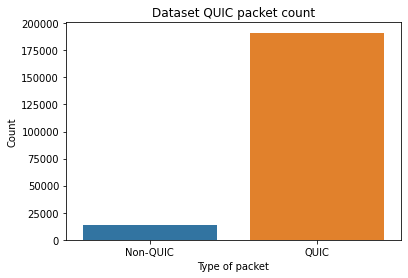

In [114]:
packet_protocol = dataset["quic"]
packet_protocol = ["QUIC" if x else "Non-QUIC" for x in packet_protocol]

print("Total packets: {0}".format(len(packet_protocol)))
print(dataset["quic"].value_counts())

chart = sns.countplot(packet_protocol)
plt.title("Dataset QUIC packet count")
plt.xlabel("Type of packet")
plt.ylabel("Count")
plt.show()


Preprocess dataset

- Extract quic column data and remove from dataset.
- Remove the string related feilds.
- Remove empty feilds


In [116]:
def preprocess(ds):

    # 1. Remove the strings columnns from dataset.
    # eth.src, eth.dst, ip.src, ip.dst, ip.tos, ip.id, ip.flags, ip.checksum, ip.dsfield, checksum
    ds.drop(
        [
            "eth.src",
            "eth.dst",
            "ip.src",
            "ip.dst",
            "ip.tos",
            "ip.id",
            "ip.flags",
            "ip.checksum",
            "ip.dsfield",
            "checksum",
        ],
        axis=1,
        inplace=True,
    )

    # 2. Remove the invalid rows ie axis=0 from the dataset.
    ds.dropna(axis=0, inplace=True)

    # 3. After deleting the rows, reset the index column and delete it.
    ds.reset_index(drop=True)

    # 4. Get the result(quic) column values and remove dataset.
    targets = list(ds["quic"].values)
    ds.drop(ds.columns[len(ds.columns) - 1], axis=1, inplace=True)

    print(ds.info())
    return ds, targets


initial_size = dataset.size
clean_dataset, targets = preprocess(clean_dataset)
final_size = clean_dataset.size

if clean_dataset.isnull().values.any():
    print("Failed to clean dataset. There are NaN/null values in dataset.")
    nan_cols = [i for i in clean_dataset.columns if clean_dataset[i].isnull().any()]
    print("Columns with null values: ", *nan_cols)
    exit(1)


print(
    "\nDataset size: {0} = {1}, Cleaned dataset size: {2} = {3}, Percentage: {4}%".format(
        dataset.shape,
        initial_size,
        clean_dataset.shape,
        final_size,
        round(100 - (final_size / initial_size) * 100, 2),
    )
)


KeyError: "['eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'ip.tos', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'checksum'] not found in axis"

Split train and test


In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(
    clean_dataset, targets, test_size=0.30, random_state=7, shuffle=True
)

clean_dataset.reset_index(drop=True, inplace=True)
clean_dataset.to_csv("cleaned-dataset.csv")
clean_dataset

# prepare the cross-validation procedure
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

X = clean_dataset
Y = targets
X, Y = make_classification(
    n_samples=100, n_features=16, n_informative=16, n_redundant=0, random_state=7
)
cv = KFold(n_splits=4, random_state=7, shuffle=True)


Size and Train data colunmns


In [118]:
print("Size of test: {0}, {1}".format(len(X_test), len(Y_test)))
print("Size of train: {0}, {1}".format(len(X_train), len(Y_train)))

X_train


Size of test: 61419, 61419
Size of train: 143308, 143308


,frame.encap_type,frame.time_epoch,frame.len,frame.cap_len,ip.version,ip.hdr_len,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.len,srcport,dstport,length
112061,1,1.645532e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,1278.0,443,56480,1258
113435,1,1.645532e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,1278.0,443,56480,1258
181792,1,1.645533e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,1278.0,443,51905,1258
146032,1,1.645533e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,1278.0,443,52119,1258
3378,1,1.645532e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,122.0,17.0,1278.0,443,55844,1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53476,1,1.645532e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,1278.0,443,56480,1258
10746,1,1.645532e+09,1127,1127,4,20.0,0.0,1.0,0.0,0.0,128.0,17.0,1113.0,56453,443,1093
49706,1,1.645532e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,1278.0,443,56480,1258
189748,1,1.645534e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,1278.0,443,51905,1258


Logistic Regression


In [119]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Fitting the logistic regression algorithm to training dataset
model = LogisticRegression(random_state = 7)
clf = model.fit(X_train, Y_train)
predict = clf.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "LogisticRegression"))

print(classification_report(Y_test, predict, output_dict=True))
score = model.score(X_test, Y_test) * 100
metrics["LogisticRegression"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["LogisticRegression"].update({"CVAccuracy": mean(score)})
    # print(scores)
except:
    metrics["LogisticRegression"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: P

Model predicted non quic packet:  [1]
Model predicted quic packet:  [1]
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4017}, '1': {'precision': 0.9345967860108435, 'recall': 1.0, 'f1-score': 0.9661928446991693, 'support': 57402}, 'accuracy': 0.9345967860108435, 'macro avg': {'precision': 0.46729839300542175, 'recall': 0.5, 'f1-score': 0.48309642234958466, 'support': 61419}, 'weighted avg': {'precision': 0.8734711524217985, 'recall': 0.9345967860108435, 'f1-score': 0.9030007273225178, 'support': 61419}}
Acuracy: 93.45967860108435%
CV Accuracy: 77.000 (0.121)
CPU times: user 1.94 s, sys: 638 ms, total: 2.58 s
Wall time: 1.11 s


Decision tree


In [120]:
%%time

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "DecisionTreeClassifier"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["DecisionTree"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["DecisionTree"].update({"CVAccuracy": mean(score)})
    # print(scores)
except:
    metrics["DecisionTree"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [0]
Model predicted quic packet:  [1]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4017
           1       1.00      1.00      1.00     57402

    accuracy                           1.00     61419
   macro avg       1.00      1.00      1.00     61419
weighted avg       1.00      1.00      1.00     61419

Acuracy: 99.98860287533174%
CV Accuracy: 78.000 (0.066)
CPU times: user 401 ms, sys: 21 ms, total: 422 ms
Wall time: 971 ms


Random Forset


In [121]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
report = classification_report(Y_test, predictions)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "RandomForestClassifier"))

print(report)
score = model.score(X_test, Y_test) * 100
metrics["RandomForest"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores), std(scores)))
    metrics["RandomForest"].update({"CVAccuracy": mean(score)})
except:
    metrics["RandomForest"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [0]
Model predicted quic packet:  [0]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4017
           1       1.00      1.00      1.00     57402

    accuracy                           1.00     61419
   macro avg       1.00      1.00      1.00     61419
weighted avg       1.00      1.00      1.00     61419

Acuracy: 99.92510460932284%
CV Accuracy: 0.760 (0.085)
CPU times: user 7.21 s, sys: 85.8 ms, total: 7.3 s
Wall time: 7.99 s


Feature importance for random forest


frame.encap_type    0.000000
frame.time_epoch    0.096465
frame.len           0.044475
frame.cap_len       0.046247
ip.version          0.000000
ip.hdr_len          0.000000
ip.flags.rb         0.000000
ip.flags.df         0.007585
ip.flags.mf         0.000000
ip.frag_offset      0.000000
ip.ttl              0.127363
ip.proto            0.060877
ip.len              0.055477
srcport             0.239978
dstport             0.210431
length              0.111101
dtype: float64


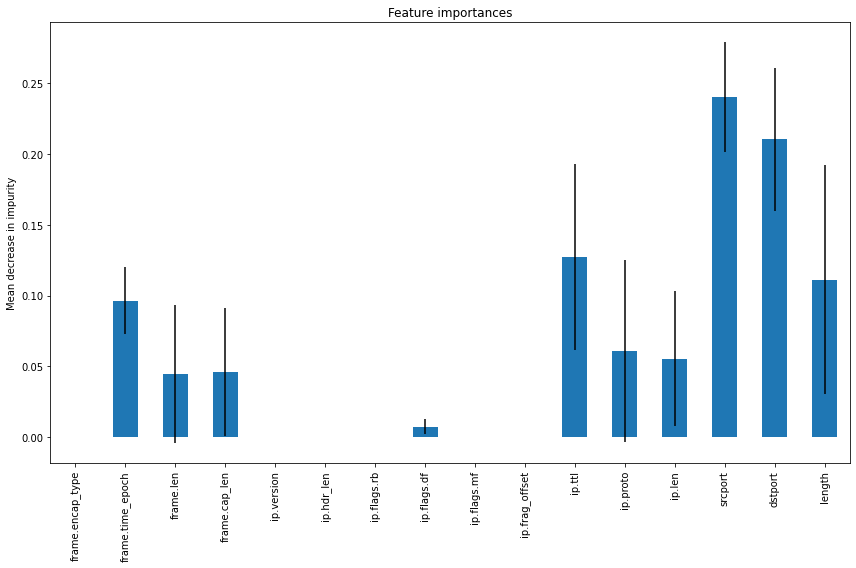

CPU times: user 769 ms, sys: 198 ms, total: 966 ms
Wall time: 289 ms


In [105]:
%%time

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

features = list(clean_dataset.columns)
classifier_importances = pd.Series(importances, index=features)
print(classifier_importances)

fig, ax = plt.subplots()
classifier_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout(rect=(0, 0, 2, 2))
plt.show()


Gradient boosting


In [122]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "GradientBoostingClassifier"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["GradientBoosting"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["GradientBoosting"].update({"CVAccuracy": mean(score)})
except:
    metrics["GradientBoosting"].update({"CVAccuracy": 0})


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [0]
Model predicted quic packet:  [1]
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      4017
           1       0.99      1.00      1.00     57402

    accuracy                           0.99     61419
   macro avg       0.99      0.96      0.98     61419
weighted avg       0.99      0.99      0.99     61419

Acuracy: 99.44968169458961%
CV Accuracy: 83.000 (0.059)
CPU times: user 8.29 s, sys: 261 ms, total: 8.55 s
Wall time: 8.73 s


NaiveBayes

In [123]:
%%time

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

model = BernoulliNB()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "NaiveBayes"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["NaiveBayes"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["NaiveBayes"].update({"CVAccuracy": mean(score)})
except:
    metrics["NaiveBayes"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [1]
Model predicted quic packet:  [0]
              precision    recall  f1-score   support

           0       1.00      0.05      0.10      4017
           1       0.94      1.00      0.97     57402

    accuracy                           0.94     61419
   macro avg       0.97      0.53      0.53     61419
weighted avg       0.94      0.94      0.91     61419

Acuracy: 93.78856705579707%
CV Accuracy: 79.000 (0.059)
CPU times: user 1.08 s, sys: 396 ms, total: 1.48 s
Wall time: 773 ms


KNN Algorithm


In [126]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "KNeighborsClassifier"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["KNN"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["KNN"].update({"CVAccuracy": mean(score)})
    # print(scores)
except:
    metrics["KNN"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [0]
Model predicted quic packet:  [0]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4017
           1       1.00      1.00      1.00     57402

    accuracy                           1.00     61419
   macro avg       0.99      0.99      0.99     61419
weighted avg       1.00      1.00      1.00     61419

Acuracy: 99.73135348996239%
CV Accuracy: 84.000 (0.063)
CPU times: user 7min 27s, sys: 3min 17s, total: 10min 45s
Wall time: 5min 57s


Plot accuracy


{'LogisticRegression': {'Accuracy': 93.45967860108435, 'CVAccuracy': 93.45967860108435}, 'DecisionTree': {'Accuracy': 99.98860287533174, 'CVAccuracy': 99.98860287533174}, 'RandomForest': {'Accuracy': 99.92510460932284, 'CVAccuracy': 99.44968169458961}, 'GradientBoosting': {'Accuracy': 99.44968169458961}, 'NaiveBayes': {'Accuracy': 93.78856705579707, 'CVAccuracy': 93.78856705579707}, 'KNN': {'Accuracy': 99.73135348996239, 'CVAccuracy': 99.73135348996239}}
LogisticRegression                  93.45967860108435%
DecisionTree                        99.98860287533174%
RandomForest                        99.92510460932284%
GradientBoosting                    99.44968169458961%
NaiveBayes                          93.78856705579707%
KNN                                 99.73135348996239%


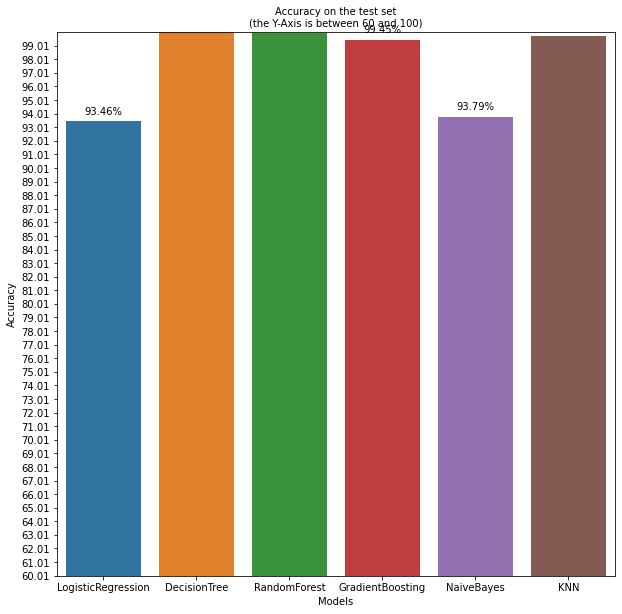

In [127]:
ticks = []
accuracy = []
models_accuracy = []
print(metrics)
for k, v in metrics.items():
    accuracy.append(v["Accuracy"])
    models_accuracy.append([k, v["Accuracy"]])
    print("{0:<35} {1}%".format(k, v["Accuracy"]))

df_acc = pd.DataFrame(models_accuracy)
df_acc.columns = ["Models", "Accuracy"]

plt.figure(figsize=(10, 10))
g = sns.barplot(x="Models", y="Accuracy", data=df_acc)
for i in range(0, 100):
    val = i + 0.01
    ticks.append(val)
g.set_yticks(ticks)
g.set_yticklabels(ticks)

plt.title("Accuracy on the test set\n(the Y-Axis is between 60 and 100)", fontsize=10)
plt.ylim(60, 100)
for i, p in enumerate(g.patches):
    percentage = "{:.2f}%".format(accuracy[i])
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height() + 0.5
    g.annotate(percentage, (x, y), ha="center")

plt.show()


Plot cross-validation accuracy

In [136]:
ticks = []
accuracy = []
models_accuracy = []

for k, v in metrics.items():
    try:
        accuracy.append(v["CVAccuracy"])
        models_accuracy.append([k, v["CVAccuracy"]])
        print("{0:<35} {1}%".format(k, v["CVAccuracy"]))

    except KeyError:
        accuracy.append(10.30)
        models_accuracy.append(10.30)
        print("{0:<35} {1}%".format(k, 01.03))
        continue


df_acc = pd.DataFrame(models_accuracy)
df_acc.columns = ["Models", "CVAccuracy"]

plt.figure(figsize=(10, 10))
g = sns.barplot(x="Models", y="CVAccuracy", data=df_acc)
for i in range(0, 100):
    val = i + 0.01
    ticks.append(val)
g.set_yticks(ticks)
g.set_yticklabels(ticks)

plt.title("Accuracy on the test set\n(the Y-Axis is between 60 and 100)", fontsize=10)
plt.ylim(60, 100)
for i, p in enumerate(g.patches):
    percentage = "{:.2f}%".format(accuracy[i])
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height() + 0.5
    g.annotate(percentage, (x, y), ha="center")

plt.show()


LogisticRegression                  93.45967860108435%
DecisionTree                        99.98860287533174%
RandomForest                        99.44968169458961%
GradientBoosting                    1.03%
NaiveBayes                          93.78856705579707%
KNN                                 99.73135348996239%


TypeError: object of type 'float' has no len()